In [71]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from torch.autograd import Variable

plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
from torch.utils.data import Dataset

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn import functional

import time
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()

MAX_LENGTH = 5 #temp

MAX_VOCAB_SIZE = 1000

PAD_IDX = 0 
SOS_token = 1
EOS_token = 2
UNK_IDX = 3

In [72]:
import torch
from torch.nn import functional
from torch.autograd import Variable

def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.range(0, max_len - 1).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length))

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """
    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = functional.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss


# Remove punctuation
def removePunctuation(s):

    to_remove = ('&lt;', '&gt;', '&amp;', '&apos;', '&quot;')
    table = str.maketrans(dict.fromkeys('.!?:,'))
    s = s.translate(table)
    for i in to_remove:
        s=s.replace(i,'')   
    s = s.strip()
    
    return s


from typing import List
from collections import Counter, namedtuple
from itertools import zip_longest

def tokenize_13a(line):
    """
    Tokenizes an input line using a relatively minimal tokenization that is however equivalent to mteval-v13a, used by WMT.
    :param line: a segment to tokenize
    :return: the tokenized line
    """

    norm = line

    # language-independent part:
    norm = norm.replace('<skipped>', '')
    norm = norm.replace('-\n', '')
    norm = norm.replace('\n', ' ')
    norm = norm.replace('&quot;', '"')
    norm = norm.replace('&amp;', '&')
    norm = norm.replace('&lt;', '<')
    norm = norm.replace('&gt;', '>')

    # language-dependent part (assuming Western languages):
    norm = " {} ".format(norm)
    norm = re.sub(r'([\{-\~\[-\` -\&\(-\+\:-\@\/])', ' \\1 ', norm)
    norm = re.sub(r'([^0-9])([\.,])', '\\1 \\2 ', norm)  # tokenize period and comma unless preceded by a digit
    norm = re.sub(r'([\.,])([^0-9])', ' \\1 \\2', norm)  # tokenize period and comma unless followed by a digit
    norm = re.sub(r'([0-9])(-)', '\\1 \\2 ', norm)  # tokenize dash when preceded by a digit
    norm = re.sub(r'\s+', ' ', norm)  # one space only between words
    norm = re.sub(r'^\s+', '', norm)  # no leading space
    norm = re.sub(r'\s+$', '', norm)  # no trailing space

    return norm

def corpus_bleu(sys_stream, ref_streams, smooth='exp', smooth_floor=0.0, force=False, lowercase=False,
                 use_effective_order=False):
    """Produces BLEU scores along with its sufficient statistics from a source against one or more references.
    :param sys_stream: The system stream (a sequence of segments)
    :param ref_streams: A list of one or more reference streams (each a sequence of segments)
    :param smooth: The smoothing method to use
    :param smooth_floor: For 'floor' smoothing, the floor to use
    :param force: Ignore data that looks already tokenized
    :param lowercase: Lowercase the data
    :param tokenize: The tokenizer to use
    :return: a BLEU object containing everything you'd want
    """

    # Add some robustness to the input arguments
    if isinstance(sys_stream, str):
        sys_stream = [sys_stream]
    if isinstance(ref_streams, str):
        ref_streams = [[ref_streams]]

    sys_len = 0
    ref_len = 0

    correct = [0 for n in range(NGRAM_ORDER)]
    total = [0 for n in range(NGRAM_ORDER)]
    

    # look for already-tokenized sentences
    tokenized_count = 0

    fhs = [sys_stream] + ref_streams
    for lines in zip_longest(*fhs):
        if None in lines:
            raise EOFError("Source and reference streams have different lengths!")

        if lowercase:
            lines = [x.lower() for x in lines]
            
        tokenize= 'tokenize_13a'    

        if not (force or tokenize == 'none') and lines[0].rstrip().endswith(' .'):
            tokenized_count += 1

            if tokenized_count == 100:
                logging.warning('That\'s 100 lines that end in a tokenized period (\'.\')')
                logging.warning('It looks like you forgot to detokenize your test data, which may hurt your score.')
                logging.warning('If you insist your data is detokenized, or don\'t care, you can suppress this message with \'--force\'.')

        output, *refs = [tokenize_13a(x.rstrip()) for x in lines]
        

        ref_ngrams, closest_diff, closest_len = ref_stats(output, refs)
        

        sys_len += len(output.split())
        ref_len += closest_len

        sys_ngrams = extract_ngrams(output)
        for ngram in sys_ngrams.keys():
            n = len(ngram.split())
            correct[n-1] += min(sys_ngrams[ngram], ref_ngrams.get(ngram, 0))
            total[n-1] += sys_ngrams[ngram]
            

    return compute_bleu(correct, total, sys_len, ref_len, smooth, smooth_floor, use_effective_order)
  

In [73]:
NGRAM_ORDER = 4
  
def compute_bleu(correct: List[int], total: List[int], sys_len: int, ref_len: int, smooth = 'none', smooth_floor = 0.01,
                 use_effective_order = False):
    """Computes BLEU score from its sufficient statistics. Adds smoothing.
    :param correct: List of counts of correct ngrams, 1 <= n <= NGRAM_ORDER
    :param total: List of counts of total ngrams, 1 <= n <= NGRAM_ORDER
    :param sys_len: The cumulative system length
    :param ref_len: The cumulative reference length
    :param smooth: The smoothing method to use
    :param smooth_floor: The smoothing value added, if smooth method 'floor' is used
    :param use_effective_order: Use effective order.
    :return: A BLEU object with the score (100-based) and other statistics.
    """

    precisions = [0 for x in range(NGRAM_ORDER)]

    smooth_mteval = 1.
    effective_order = NGRAM_ORDER
    for n in range(NGRAM_ORDER):
        if total[n] == 0:
            break

        if use_effective_order:
            effective_order = n + 1

        if correct[n] == 0:
            if smooth == 'exp':
                smooth_mteval *= 2
                precisions[n] = 100. / (smooth_mteval * total[n])
            elif smooth == 'floor':
                precisions[n] = 100. * smooth_floor / total[n]
        else:
            precisions[n] = 100. * correct[n] / total[n]

    # If the system guesses no i-grams, 1 <= i <= NGRAM_ORDER, the BLEU score is 0 (technically undefined).
    # This is a problem for sentence-level BLEU or a corpus of short sentences, where systems will get no credit
    # if sentence lengths fall under the NGRAM_ORDER threshold. This fix scales NGRAM_ORDER to the observed
    # maximum order. It is only available through the API and off by default

    brevity_penalty = 1.0
    if sys_len < ref_len:
        brevity_penalty = math.exp(1 - ref_len / sys_len) if sys_len > 0 else 0.0
        

    bleu = brevity_penalty * math.exp(sum(map(my_log, precisions[:effective_order])) / effective_order)

    return bleu 
  

In [74]:
  
def ref_stats(output, refs):
    ngrams = Counter()
    closest_diff = None
    closest_len = None
    for ref in refs:
        tokens = ref.split()
        reflen = len(tokens)
        diff = abs(len(output.split()) - reflen)
        if closest_diff is None or diff < closest_diff:
            closest_diff = diff
            closest_len = reflen
        elif diff == closest_diff:
            if reflen < closest_len:
                closest_len = reflen

        ngrams_ref = extract_ngrams(ref)
        for ngram in ngrams_ref.keys():
            ngrams[ngram] = max(ngrams[ngram], ngrams_ref[ngram])

    return ngrams, closest_diff, closest_len
  

In [75]:
  
def extract_ngrams(line, min_order=1, max_order=NGRAM_ORDER) -> Counter:
    """Extracts all the ngrams (1 <= n <= NGRAM_ORDER) from a sequence of tokens.
    :param line: a segment containing a sequence of words
    :param max_order: collect n-grams from 1<=n<=max
    :return: a dictionary containing ngrams and counts
    """

    ngrams = Counter()
    tokens = line.split()
    for n in range(min_order, max_order + 1):
        for i in range(0, len(tokens) - n + 1):
            ngram = ' '.join(tokens[i: i + n])
            ngrams[ngram] += 1

    return ngrams  

def my_log(num):
    """
    Floors the log function
    :param num: the number
    :return: log(num) floored to a very low number
    """

    if num == 0.0:
        return -9999999999
    return math.log(num)
  

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2index = {"PAD" : 0, "<SOS>" : 1, "EOS" : 2, "UNK" : 3}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "<SOS>", 2: "EOS", 3: "UNK"}
        self.n_words = 4  # Count SOS and EOS and Pad
        self.all_words = []

    def addSentence(self, sentence):
        'Add all words from all sentences'
        for word in sentence.split(' '):
            if word.strip(): #if not empty space
                self.all_words.append(word)
                
                
    def build_vocab(self, vocab_size=MAX_VOCAB_SIZE):
        'Build vocabulary of vocab_size most common words'
        
        token_counter = Counter(self.all_words)
        vocab, count = zip(*token_counter.most_common(vocab_size)) #* unzips the tuples
        for word in vocab:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
def remove_blanks(pair):
    '''Remove empty lines'''
    if len(pair[0]) == 0 and len(pair[1]) == 0:
        return False
    else:
        return True
    
def set_max_length(pair, max_length=MAX_LENGTH):
    if len(pair[0].split(' ')) > max_length or len(pair[1].split(' '))>max_length:
        return False
    else:
        return True
    
def readLangs(filename1, filename2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    with open(filename1, encoding='utf-8') as f:
        lines1 = f.read().strip().split('\n')
        
    with open(filename2, encoding='utf-8') as f:
        lines2 = f.read().strip().split('\n')   
        
    # Remove punctuation
    lines1 = [removePunctuation(l) for l in lines1]
    lines2 = [removePunctuation(l) for l in lines2]
              
    # Reverse pairs, make Lang instances
    if reverse: #change from english->french to french->english for example
        pairs =list(zip(lines2, lines1))
        input_lang = Lang(filename2[-2:]) #take last two letters
        output_lang = Lang(filename1[-2:])
    else:
        pairs =list(zip(lines1, lines2))
        input_lang = Lang(filename1[-2:])
        output_lang = Lang(filename2[-2:])
            
        

    pairs = list(filter(remove_blanks, pairs))  
    pairs = list(filter(set_max_length, pairs))

    return input_lang, output_lang, pairs 


def prepareData(lang1, lang2, num_sent=None, reverse=False):
    
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    
    pairs = pairs[:num_sent]
    print("Read %s sentence pairs" % len(pairs))
    
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    input_lang.build_vocab()
    output_lang.build_vocab()
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs


class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple, word2id_lang1, word2id_lang2):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_list1, self.data_list2 = zip(*data_tuple)
        assert (len(self.data_list1) == len(self.data_list2))
        self.word2id1 = word2id_lang1
        self.word2id2 = word2id_lang2

    def __len__(self):
        return len(self.data_list1)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        
        input_sentence = [self.word2id1[c] if c in self.word2id1.keys() 
                         else UNK_IDX for c in self.data_list1[key].split()][:MAX_LENGTH-1]
        input_sentence.append(EOS_token)
                                                                   
        output_sentence = [self.word2id2[c] if c in self.word2id2.keys() 
                          else UNK_IDX for c in self.data_list2[key].split()][:MAX_LENGTH-1]
        output_sentence.append(EOS_token)

        return [input_sentence, output_sentence, len(input_sentence), len(output_sentence)]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    length_list1 = []
    length_list2 = []
     
    # padding
    for datum in batch:
        x1 = datum[0]
        x2 = datum[1]
        len1 = datum[2]
        len2 = datum[3]
        
        length_list1.append(len1)
        length_list2.append(len2)
        #Pad first sentences
        padded_vec1 = np.pad(np.array(x1),
                                pad_width=((0,MAX_LENGTH-len1)),
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        
        #Pad second sentences
        padded_vec2 = np.pad(np.array(x2),
                        pad_width=((0,MAX_LENGTH-len2)),
                        mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
        
    data_list1 = np.array(data_list1)
    data_list2 = np.array(data_list2)
    length_list1 = np.array(length_list1)
    lenth_list2 = np.array(length_list2)
    
    return [torch.from_numpy(np.array(data_list1)), 
            torch.from_numpy(np.array(data_list2)),
            torch.LongTensor(length_list1), 
            torch.LongTensor(length_list2)]


class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, dropout=0):
        '''Bidirectional RNN'''
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        # Embedding input: max_length x batch_size
        # Embedding output: max_length x batch_size x hidden size
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0) #vocab size x hidden size
        
        # Input: (max_length x batch_size x hidden_size)
        # Output: hidden - 2 x batch_size x hidden_size
        # Output: outputs max_length x batch_size x hidden_size*2
        self.gru = nn.GRU(hidden_size, hidden_size, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        outputs, hidden = self.gru(embedded, hidden)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden
    
    
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()

        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_weights = Variable(torch.zeros(this_batch_size, max_len)).to(device) # B x S

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_weights[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        return F.softmax(attn_weights, dim=1).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
            
        weights = self.attn(torch.cat((hidden, encoder_output), 1))
        weights = self.v.mm(weights.transpose(0,1))
        return weights
    

class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = MAX_LENGTH
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step, but will use all encoder outputs
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).unsqueeze(0) #so that we have 1 x batch x hidden
        word_embedded = self.dropout(word_embedded)
        
        # Implement attention
        attn_weights = self.attn(last_hidden, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)).transpose(0,1) # 1 x batch x hidden
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        output = self.softmax(self.out(output[0]))
        
        # Return final output, hidden state, and attention weights 
        return output, hidden, attn_weights
        
    
def train(inputs, input_lengths, targets, target_lengths, 
          encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH,
         teacher_forcing_ratio=0.5, clip = 5):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 #
    batch_size = inputs.size()[1]
    #print('input size', inputs.size())
    #print('batch size', batch_size)
    max_targ_len = max_length

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(inputs, input_lengths, None)

    
    # Prepare input and output variables
    decoder_input = torch.LongTensor([SOS_token] * batch_size).to(device)
    decoder_hidden = encoder_hidden[:1] # Use last (forward) hidden state from encoder
    
    #print('time 1 size', decoder_input.size())
    #print('time 1 hidden size', decoder_hidden.size())
    
    #randomly use teacher forcing or not
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Run through decoder one time step at a time using TEACHER FORCING=1.0
    all_decoder_outputs = Variable(torch.zeros(max_targ_len, batch_size, output_lang.n_words))
    

    if use_teacher_forcing:
        for t in range(max_targ_len):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            all_decoder_outputs[t] = decoder_output
            decoder_input = targets[t]
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(max_targ_len):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)

            decoder_input = topi.squeeze().detach()  # detach from history as input
            
            all_decoder_outputs[di] = decoder_output

    loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    targets.transpose(0, 1).contiguous(),
    target_lengths)
        
    loss.backward()
        
    # Clip gradient norms
    clip = clip
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    
    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()


def trainIters(loader, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01,
              teacher_forcing_ratio=0.5):
    
    start = time.time()
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    print_loss_total = 0
    plot_loss_total = 0
    plot_losses = []

    counter = 0
    epoch = 0

    while epoch < n_iters:
        epoch += 1

        # Get training data for this cycle
        for i, (source, target, lengths1, lengths2) in enumerate(loader):

            counter += 1

            # Run the train function
            loss = train(
                source.long().transpose(0,1), lengths1, target.long().transpose(0,1), lengths2,
                encoder, decoder,
                encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=teacher_forcing_ratio
            )

            # Keep track of loss
            print_loss_total += loss
            plot_loss_total += loss


            if counter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_iters), epoch, 
                                                       epoch / n_iters * 100, print_loss_avg)
                print(print_summary)


            if counter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses)
    return plot_losses


def evaluate(encoder, decoder, sentence, input_lengths, translated, search='greedy', max_length=MAX_LENGTH):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    with torch.no_grad():
        input_tensor = sentence.transpose(0,1)
        input_length = sentence.size()[0]
        
        # encode the source lanugage
        encoder_output, encoder_hidden = encoder(input_tensor, input_lengths, None)

        decoder_input = torch.tensor([SOS_token], device=device)  # SOS
        decoder_hidden = encoder_hidden[:1] # Use last (forward) hidden state from encoder 
        # output of this function
        decoded_words = []

        for di in range(max_length):
            # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_output)
            
            # hint: print out decoder_output and decoder_attention
            # TODO: add your code here to populate decoded_words and decoder_attentions
            # TODO: do this in 2 ways discussed in class: greedy & beam_search
            
            # GREEDY
            topv, topi = decoder_output.data.topk(1) 

            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break

            else:
                if topi.item() not in [SOS_token, EOS_token, UNK_IDX, PAD_IDX]:
                    decoded_words.append(output_lang.index2word[topi.item()])
            
            decoder_input = topi[0].detach()
        
        translation = []
        for i in translated: #expected translation
            if i.item() not in [SOS_token, EOS_token, UNK_IDX, PAD_IDX]:
                translation.append(output_lang.index2word[i.item()])

        return decoded_words, translation
    
    
def evaluate_batch(loader, encoder, decoder):
    
    decoded_sentences = []
    actual_sentences = []
    
    for i, (source, target, lengths1, lengths2) in enumerate(loader):
        #iterate over batch
        
        for n in range(len(source)):
            # Go sentence by sentence
            
            decoded, actual = evaluate(encoder, decoder, source[n].unsqueeze(0), lengths1[n], target[n])
            decoded_sentences.append(decoded)
            actual_sentences.append(actual)
            
    return decoded_sentences, actual_sentences


def evaluate_bleu(translation_list, reference_list):
     
    translations = ' '.join(r for v in translation_list for r in v)
    references = ' '.join(r for v in reference_list for r in v)
    
    return corpus_bleu(translations, references)

#Plot results
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))    

def showAttention(input_sentence, output_words, attentions):
    """
    Function that takes in attention and visualize the attention.
    @param - input_sentence: string the represent a list of words from source language
    @param - output_words: the gold translation in target language
    @param - attentions: a numpy array
    """
    # Set up figure with colorbar    

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # TODO: Add your code here to visualize the attention
    # look at documentation for imshow https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.matshow.html

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

In [76]:
en_loc = 'iwslt-vi-en'

In [77]:
input_lang, output_lang, pairs = prepareData(en_loc+'/train.tok.vi', en_loc+'/train.tok.en', num_sent=100)

Reading lines...
Read 100 sentence pairs
Counting words...
Counted words:
vi 233
en 216


In [78]:
input_lang_v, output_lang_v, pairs_v = prepareData(en_loc+'/dev.tok.vi', en_loc+'/dev.tok.en', num_sent=100)

Reading lines...
Read 61 sentence pairs
Counting words...
Counted words:
vi 130
en 114


/Users/preetgandhi95/miniconda3/envs/nlpclass/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/preetgandhi95/miniconda3/envs/nlpclass/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  if __name__ == '__main__':


0m 11s (- 28m 53s) (13 0%) 5.1024
0m 21s (- 27m 53s) (25 1%) 4.5195
0m 31s (- 26m 54s) (38 1%) 4.3315
0m 41s (- 26m 54s) (50 2%) 4.1953
0m 51s (- 26m 23s) (63 3%) 4.0996
1m 1s (- 26m 15s) (75 3%) 4.0166
1m 11s (- 25m 48s) (88 4%) 3.9305
1m 21s (- 25m 43s) (100 5%) 3.8440
1m 31s (- 25m 24s) (113 5%) 3.8049
1m 41s (- 25m 18s) (125 6%) 3.7826
1m 51s (- 25m 3s) (138 6%) 3.7388
2m 1s (- 24m 55s) (150 7%) 3.6441
2m 11s (- 24m 41s) (163 8%) 3.5924
2m 21s (- 24m 34s) (175 8%) 3.5692
2m 31s (- 24m 20s) (188 9%) 3.5482
2m 41s (- 24m 12s) (200 10%) 3.5384
2m 51s (- 23m 58s) (213 10%) 3.4665
3m 1s (- 23m 51s) (225 11%) 3.4515
3m 11s (- 23m 37s) (238 11%) 3.4475
3m 21s (- 23m 27s) (250 12%) 3.4053
3m 31s (- 23m 14s) (263 13%) 3.3757
3m 41s (- 23m 6s) (275 13%) 3.3071
3m 51s (- 22m 54s) (288 14%) 3.2025
4m 1s (- 22m 45s) (300 15%) 3.2501
4m 11s (- 22m 34s) (313 15%) 3.2448
4m 21s (- 22m 26s) (325 16%) 3.2124
4m 31s (- 22m 15s) (338 16%) 3.1490
4m 41s (- 22m 7s) (350 17%) 3.1654
4m 51s (- 21m 55s) (3

<Figure size 432x288 with 0 Axes>

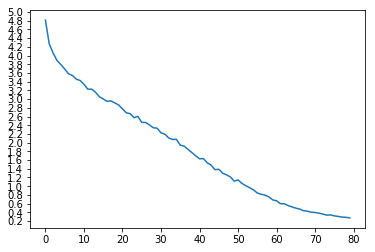

In [85]:
BATCH_SIZE=32
hidden_size=256

train_dataset = VocabDataset(pairs, input_lang.word2index, output_lang.word2index)
# 1 batch input dimension: num_sentences x max sentence length
# 1 batch: source_sentences, target_sentences, source_lengths, target_lengths
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

encoder = EncoderRNN(hidden_size = hidden_size, vocab_size = input_lang.n_words )
decoder = BahdanauAttnDecoderRNN(hidden_size, output_lang.n_words)

plot_losses = trainIters(train_loader, encoder, decoder, n_iters=2000, 
                         print_every=50, plot_every=100, learning_rate=0.01, teacher_forcing_ratio=0.5)

In [88]:
decoded, actual = evaluate_batch(train_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected: ['He', 'was', 'looking', 'at']
Actual: ['He', 'was', 'looking', 'at']


Expected: ['Don', 't', 'start', 'wrestling']
Actual: ['Don', 't', 'start', 'wrestling']


Expected: ['Umar', 'was', 'paralyzed', 'for']
Actual: ['Umar', 'was', 'paralyzed', 'for']


Expected: ['This', 'is', 'Chet', 'Baker']
Actual: ['This', 'is', 'Chet', 'Baker']


Expected: ['Thank', 'you']
Actual: ['Thank', 'you']


Expected: ['Francesca', 'Fedeli', 'Ciao']
Actual: ['Francesca', 'Fedeli', 'Ciao']


Expected: ['Cows', 'with', 'a', 'view']
Actual: ['Cows', 'with', 'a', 'view']


Expected: ['Here', 'is', 'the', 'thing']
Actual: ['Here', 'is', 'the', 'thing']


Expected: ['So', 'congratulations']
Actual: ['So', 'congratulations']


Expected: ['Thank', 'you', 'very', 'much']
Actual: ['Thank', 'you', 'very', 'much']


Expected: ['Thank', 'you', 'very', 'much']
Actual: ['Thank', 'you', 'very', 'much']


Expected: ['Something', 'crazy', 'also', 'happened']
Actual: ['Something', 'crazy', 'also', 'happened']




In [87]:
evaluate_bleu(decoded, actual)

95.43900451104247